In [504]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

## Read data and save in X and y

- the data X returned is in the form of a list of dictionaries, where each dictionary contains the features of a data point

> ex: X[0] = {1: -0.993496, 2: -0.993043, 3: -0.850291, 4: -0.963479, 5: -0.960727, 6: -0.900596, 7: -0.96642, 8: -0.863996, 9: -0.606175, 10: -0.999291, 11: 0.0811894, 12: 0.651101}
- the label y is a list of floats

> ex: y[0] = 90.0

In [505]:
def read_libsvm_format(file_path):
    X, y = [], []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            y.append(float(parts[0]))  
            features = {}
            for item in parts[1:]:
                index, value = item.split(":")
                features[int(index)] = float(value)
            X.append(features)
    return X, y

X, y = read_libsvm_format('cpusmall_scale')

In [506]:
print(len(X))
print(X[0])
print(y[0])

8192
{1: -0.993496, 2: -0.993043, 3: -0.850291, 4: -0.963479, 5: -0.960727, 6: -0.900596, 7: -0.96642, 8: -0.863996, 9: -0.606175, 10: -0.999291, 11: 0.0811894, 12: 0.651101}
90.0


## implement the sigmoid function

In [507]:
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

##  implement the sqr error function

$err_{SQR}(s, y) = (y w^T x - 1)^2, \quad s = w^T x$

In [508]:
def sqr_error(w, x, y):
    return (y * w @ x - 1) ** 2

## define variables with given values

In [509]:
N = 64
eta = 0.01
amount_of_t = 500


In [510]:
amount_of_t


500

## initialization

- `in_out_sample_error`: save the in-sample error and out of sample error for the 1126 experiments while using w_lin
- `mult_200_E_in`: save the in-sample error of w_t for every t = 200, 400, ..., 100000
- `mult_200_E_out`: save the out of sample error of w_t for every t = 200, 400, ..., 100000

$\rightarrow$ need to calculate for each $t=200, 400, ..., 100000$:
\begin{equation}
\begin{split}
\bar{E}_{in}(\vec{w}_t) = \frac{1}{1126}\sum_{i=1}^{1126}\sum_{j=1}^{64} (y_j w_t^T \vec{x}_j - 1)^2 \\
\bar{E}_{out}(\vec{w}_t) = \frac{1}{1126}\sum_{i=1}^{1126}\sum_{j=1}^{8192-64} (y_j w_t^T \vec{x}_j - 1)^2
\end{split}
\end{equation}

In [511]:
in_out_sample_error = []        
mult_200_E_in = np.zeros(amount_of_t)
mult_200_E_out = np.zeros(amount_of_t)

##  generate random sample indices

For each experiment, we randomly select $N = 64$ examples from the dataset, and save them in lists `X_sample` and `y_sample`.
- Note: We use a different seed in each experiment

In [512]:
def generate_random_sample(seed):
    np.random.seed(seed)
    random_sample_indices = np.random.choice(len(X), N, replace=False)

    return random_sample_indices

## generate out of sample indices

In [513]:
def generate_out_of_sample_ind(sample_indices):
    return [i for i in range(len(X)) if i not in sample_indices]


In [514]:
indices = generate_random_sample(2)
print(indices[:10])
out_indices = generate_out_of_sample_ind(indices)
print(out_indices[:10])
print(len(out_indices))

overlap = 2116 in out_indices
print(overlap)

[2116 7851 2120 8178 7067 6448 7870 4937 2622 3363]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
8128
False


## convert type of data points
$\rightarrow$ from dictionary to ndarray (matrix)

We pass the list of dictionaries (where each dictionary is an example in the dataset) as an input into this function, then in this function, we examine over all the examples, and for each example we do the followings:

1. initialize the input vector to $[1 \ 0 \ 0 \dots \ 0 \ 0] \in \mathbb{R}^{13}$
2. update the dictionary content to the input vetor
3. append this input vetor to our list `augmented_array_list`, which is a list of ndarrays
4. return while converting the resulting list into a matrix
> Note: the returning matrix is of shape (N, 13), meaning that each row represents an example


- Note that originally we need to subtract 1 because indices in libsvm format start from 1, but now we add the 0-th element (1) to each input vector, so just generate the input vector by using the original index.

In [515]:
def convert_dtype(list_of_dict):
    augmented_array_list = []
    for example in list_of_dict:
        input_vector = np.concatenate((np.array([1]), np.zeros(12)))
        for index, value in example.items():
            input_vector[index] = value        
        augmented_array_list.append(input_vector)
    return np.array(augmented_array_list)

## linear regression

In the linear regression function, we do the following steps:
1. calculate the weight vector $w_{LIN}$ by using the normal equation $w_{LIN} = (X^TX)^{-1}X^Ty$
> the inverse of $X^TX$ is calculated by using `np.linalg.inv()`, and the matrix multiplication is done by using `@`
2. calculate the in-sample error
> $E_{in}(\vec{w}_{LIN}) = \frac{1}{N}(X^T\vec{w}_{LIN} - \vec{y})^2$
3. estimate the out of sample error
> calculated similarly to the in-sample error, with the data matrix and real value array changed.

An example result looks like:

<img src = "lin_reg_result_ex.jpeg" width=350 height= 400/>


In [516]:
def linear_regression(X_in_mat, y_in_arr, X_out_mat, y_out_arr):

    w_lin = np.linalg.inv(X_in_mat.T @ X_in_mat) @ X_in_mat.T @ y_in_arr

    in_sample_error = np.mean((X_in_mat @ w_lin - y_in_arr) ** 2)
    out_of_sample_error = np.mean((X_out_mat @ w_lin - y_out_arr) ** 2)

    in_out_sample_error.append((in_sample_error, out_of_sample_error))


## stochastic gradient descent (SGD)

In each iteration, we do the followings:
1. choose a random index from the list of sample indices, and save the corresponding data in `x_i` (a dict), `y_i` (a float)
2. convert the dictionary to a proper form and save in `input_vector`
3. calculate $-\nabla err(\vec{w}_t, \vec{x}_n, y_n)$ and save in variable `negative_stochastic_gradient`
4. update $w_t$

Each time after the above things are done, we check if t is a multiple of 200, if so, calculate the in sample error and out of sample error

In [517]:
def sgd(sample_ind, X_in_mat, y_in_arr, X_out_mat, y_out_arr):

    w_t =np.zeros(12 + 1)

    for iteration in tqdm(range(1, 100001)): 
        random_index = np.random.choice(sample_ind)
        x_i = X[random_index]           
        y_i = y[random_index]

        input_vector = np.concatenate((np.array([1]), np.zeros(12)))
        for index, value in x_i.items():
            input_vector[index] = value 

        update_direction = 2 * (y_i - w_t @ input_vector) * input_vector

        w_t += eta * update_direction  

        if iteration % 200 == 0 and iteration != 0:
            error_record_index = (iteration // 200) - 1
            mult_200_E_in[error_record_index] += (np.mean((X_in_mat @ w_t - y_in_arr) ** 2))
            mult_200_E_out[error_record_index] += (np.mean((X_out_mat @ w_t - y_out_arr) ** 2))


# main function

100%|██████████| 1126/1126 [59:19<00:00,  3.16s/it]


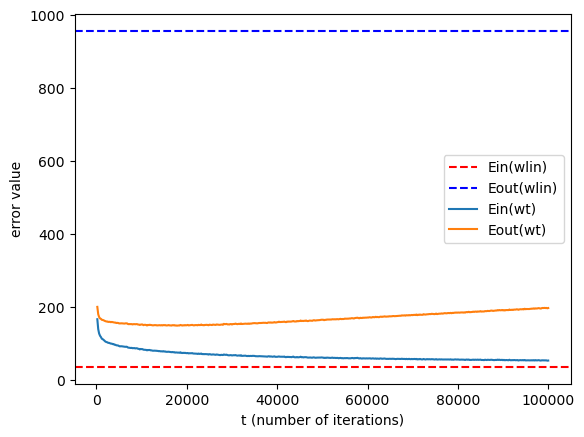

In [518]:
for experiment in tqdm(range(1126), leave = True):

    seed = experiment
    random_sample_indices = generate_random_sample(seed)
    X_sample = [X[i] for i in random_sample_indices]
    y_sample = [y[i] for i in random_sample_indices]

    out_ind = generate_out_of_sample_ind(random_sample_indices)
    X_out_of_sample = [X[i] for i in out_ind]
    y_out_of_sample = [y[i] for i in out_ind]

    X_sample_mat = convert_dtype(X_sample)
    X_out_of_sample_mat = convert_dtype(X_out_of_sample)

    y_sample_array = np.array(y_sample)
    y_out_of_sample_array = np.array(y_out_of_sample)

    linear_regression(X_sample_mat, y_sample_array, X_out_of_sample_mat, y_out_of_sample_array)
    sgd(random_sample_indices, X_sample_mat, y_sample_array, X_out_of_sample_mat, y_out_of_sample_array)

avg_in_sample = np.mean([error[0] for error in in_out_sample_error])
avg_out_sample = np.mean([error[1] for error in in_out_sample_error])
avg_in_sample_200 = mult_200_E_in / 1126
avg_out_sample_200 = mult_200_E_out / 1126

t_values = np.arange(200, 100200, 200)
plt.axhline(y=avg_in_sample, color='r', linestyle='--', label='Ein(wlin)')
plt.axhline(y=avg_out_sample, color='b', linestyle='--', label='Eout(wlin)')
plt.plot(t_values, avg_in_sample_200, label='Ein(wt)')
plt.plot(t_values, avg_out_sample_200, label='Eout(wt)')
plt.xlabel('t (number of iterations)')
plt.ylabel('error value')
plt.legend()
plt.show()


In [519]:
len(avg_in_sample_200)

500

In [520]:
avg_out_sample_200[-10:]

array([195.8830977 , 195.67439931, 196.96229189, 197.26361044,
       197.04390382, 197.43640337, 197.01409792, 197.30506212,
       196.40025841, 197.04452738])

## Value of  $E_{in}(\vec{w}_{lin})$
This value $E_{in}(\vec{w}_{lin})$ is the `avg_in_sample` in the code, and is the red dotted line in the plot.

In [521]:
avg_in_sample

35.689598963498284

## Value of  $E_{out}(\vec{w}_{lin})$
This value $E_{out}(\vec{w}_{lin})$ is the `avg_out_sample` in the code, and is the blue dotted line in the plot.

In [522]:
avg_out_sample

956.5060504597701